# Context

Recent studies have shown that breast cancer continues to be the leading cause of death among women over the world. If detected at an early stage, it can be cured in 9 out of 10 cases.

Automated detection and segmentation of cells from images are the crucial and fundamental steps for the measurement of cellular morphology that is crucial for brest cancer diagnosis and prognosis.


In this notebook, you will learn how to train a segmentation as UNet with **monai** - a framwork based Pytorch Stadard for healthcare imaging.

## Monai

MONAI is a pytorch based open source AI framework launched by NVIDIA and King’s College London.
It is integrated with training and modelling workflows in a native PyTorch Standard. t several places.


Install monai

In [1]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.9 MB/s eta 0:00:00 0:00:01


Check the installation by running the following cell

In [2]:
import monai
monai.config.print_config()

MONAI version: 1.3.2
Numpy version: 1.26.4
Pytorch version: 2.2.2+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: /opt/conda/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.22.0
scipy version: 1.13.0
Pillow version: 10.3.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.17.2+cu121
tqdm version: 4.66.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: 2.2.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml versio

#  Dataset

To train a model, we need to prepare some ingredients:

1. Dataset
2. Model
3. Loss function
4. Optimizer

# I. Create Dataset

There are two ways to create your dataset:
- with pytorch Dataset
- with monai.data.Dataset.

In this exercise, we will create our dataset using torch.utils.data.Dataset.

## 1. List all files in folder

Download the dataset from https://zenodo.org/record/1175282#.YMn_Qy-FDox

Notice that there are two kind of folder : original cell picture folder and mask folders. Using your file explorer or some code, display one image and the corresponding image

[('./TNBC_NucleiSegmentation/Slide_01/01_1.png', './TNBC_NucleiSegmentation/GT_01/01_1.png'), ('./TNBC_NucleiSegmentation/Slide_01/01_2.png', './TNBC_NucleiSegmentation/GT_01/01_2.png'), ('./TNBC_NucleiSegmentation/Slide_01/01_3.png', './TNBC_NucleiSegmentation/GT_01/01_3.png'), ('./TNBC_NucleiSegmentation/Slide_01/01_4.png', './TNBC_NucleiSegmentation/GT_01/01_4.png'), ('./TNBC_NucleiSegmentation/Slide_01/01_5.png', './TNBC_NucleiSegmentation/GT_01/01_5.png'), ('./TNBC_NucleiSegmentation/Slide_01/01_6.png', './TNBC_NucleiSegmentation/GT_01/01_6.png'), ('./TNBC_NucleiSegmentation/Slide_01/01_7.png', './TNBC_NucleiSegmentation/GT_01/01_7.png')]


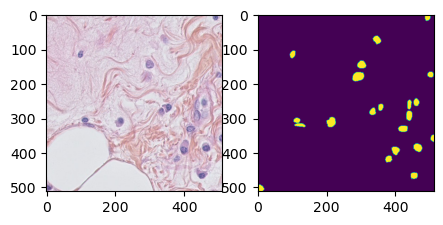

In [18]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import os

def get_images_from_folder(folder_number, base_path):
    fld_str = str(folder_number).zfill(2)
    images_pairs = []

    folder_path = f"{base_path}/GT_{fld_str}/"
    nb_images = len(os.listdir(folder_path))

    for i in range(1, nb_images):
        img_str = str(i)
        mask_image_path = f"{base_path}/GT_{fld_str}/{fld_str}_{img_str}.png"
        cell_image_path = f"{base_path}/Slide_{fld_str}/{fld_str}_{img_str}.png"
        images_pairs.append((cell_image_path, mask_image_path))
    return images_pairs
    

def display_image_pair(folder_number, image_number, base_path):
    fld_str = str(folder_number).zfill(2)
    img_str = str(image_number)
    mask_image_path = f"{base_path}/GT_{fld_str}/{fld_str}_{img_str}.png"
    cell_image_path = f"{base_path}/Slide_{fld_str}/{fld_str}_{img_str}.png"

    cell_img = mpl.image.imread(cell_image_path)
    mask_img = mpl.image.imread(mask_image_path)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
    axes[0].imshow(cell_img)
    axes[1].imshow(mask_img)

print(get_images_from_folder(1, "./TNBC_NucleiSegmentation"))

display_image_pair(2, 1, "./TNBC_NucleiSegmentation")

## 2. Define a transform
When you load your data, you need to define some transformation. For example, we want to convert image to the format [num_channels, spatial_dim_1, spatial_dim_2] because monai/pytorch use this format. We'll also need to convert the images to PyTorch tensors with transforms.ToTensor()

The following code lets you load image and the labels and define several steps to transform the data.


In [11]:
import torch

from monai.transforms import Compose, LoadImage, EnsureChannelFirst, ToTensor, NormalizeIntensity
from monai.transforms import ScaleIntensity

from monai.data import PILReader

image_trans = Compose(
    [
        LoadImage(image_only=True, reader = PILReader(converter=lambda image: image.convert("RGB"))),
        EnsureChannelFirst(),
        NormalizeIntensity(),
        ToTensor(),
    ])


label_trans = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(channel_dim="no_channel"),
        ScaleIntensity(),
        ToTensor(),
    ])


## 3. Create dataset

The following class CellDataset allows us to create our dataset from "image_files" and "label_files" where:
- "image_files" is a list of image names
- "label_files" is the list of segmentation names respectively.

"im_trans" and "label_trans" are respectively the transforms for the images and their labels.




In [25]:
import torch

class CellDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, label_files, im_trans, label_trans):
        self.image_files = image_files
        self.label_files = label_files
        self.im_trans = im_trans
        self.label_trans = label_trans

    def __len__(self):
        return(len(self.image_files))

    def __getitem__(self, index):
        return self.im_trans(self.image_files[index]), self.label_trans(self.label_files[index])



By using this class, create your training dataset et your test dataset. Remember to check if your dataset is loaded correctly.

In [88]:
pairs = [
    pair
    for i in range(1, 12)
    for pair in get_images_from_folder(i, "./TNBC_NucleiSegmentation")
]

train_size = int(len(pairs) * 0.8)

labels_train = [pair[1] for pair in pairs[:train_size]]
images_train = [pair[0] for pair in pairs[:train_size]]
labels_test = [pair[1] for pair in pairs[train_size:]]
images_test = [pair[0] for pair in pairs[train_size:]]

train_dataset = CellDataset(images_train, labels_train, image_trans, label_trans)
test_dataset = CellDataset(images_test, labels_test, image_trans, label_trans)

## 4. DataLoader

With the your dataset loaded, you have to pass it to a DataLoader. The torch.utils.data.DataLoader takes a dataset and returns batches of images and the corresponding labels. You can set various parameters like the batch size and if the data is shuffled after each epoch.


The following code let you create a data loader for the train dataset, do the same to create a test_loader on the test_dataset. Name it **test_load**


In [89]:
train_loader = torch.utils.data.DataLoader(train_dataset)
test_loader = torch.utils.data.DataLoader(test_dataset)

## 5. Now, time to check your dataloader.

Execute the code following to check if your dataloader works correctly

In [90]:
import monai
im, seg = monai.utils.misc.first(train_loader)
im.shape

torch.Size([1, 3, 512, 512])

# II. Build your segmentation model with monai

Monai already has a UNet model architecture : https://docs.monai.io/en/stable/networks.html#unet

By using the monai.networks.nets module, build a UNet model for segmentation task in 2D. You'll have to choose the following parameters for the model:

1. dimensions (number of spatial dimensions)
2. in_channels (number of input channel)
3. out_channels (number of output channel)
4. channels
5. strides


In [117]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from monai.networks.nets import UNet

model = UNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=1,
    channels=(4, 8, 16, 32, 64),
    strides=(2, 2, 2, 2),
).to(device)

# III. Define your loss function and optimizer

For a segmentation prob, we usually use DiceLoss.
Using monai.losses.DiceLoss, define your loss function and store it in the variable named **loss_function**. The option sigmoid = True should be used.




In [118]:
from monai.losses import DiceLoss

loss_function = DiceLoss(sigmoid=True)

With torch.optim, define an optimizer for your model. Use the Adam optimiser



In [119]:
from torch.optim import Adam

optimizer = Adam(model.parameters())

# IV. Trainning the model

This time, we have all ingredients to train a segmentation model: a model, an optimizer, train_loader and a loss function.  

Monai use a standard PyTorch program style for training a deep learning model.


The general process with Monai/Pytorch just for one learning step  as follows:

1. Load input and label of each batch.

2. Zero accumulated gradients with optimizer.zero_grad()

3. Compute the output from the model

4. Calculate the loss

5. Perform backprop with loss.backward()

6. Update the optimizer with optimizer.step()


Complete the following code so that it do the training


In [120]:
from tqdm import tqdm

epoch_loss_values = list()
for epoch in range(50):

    model.train()
    epoch_loss = 0
    step = 0
    for _, batch_data in tqdm(enumerate(train_loader, 0), unit="batch", total=len(train_loader)):
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()

        #compute the model predictions using the model variable and inputs
        predictions = model(inputs)

        # compute the loss using the loss function, the predictions and labels
        loss = loss_function(predictions, labels)

        # use the backward method of the loss variable to  compute the gradient of the loss used to find the minimum of the loss function
        loss.backward()

        # call the step method of the optimizer
        optimizer.step()

        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        # print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")


    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")


100%|██████████| 32/32 [00:00<00:00, 77.23batch/s]


epoch 1 average loss: 0.7823


100%|██████████| 32/32 [00:00<00:00, 77.54batch/s]


epoch 2 average loss: 0.7302


100%|██████████| 32/32 [00:00<00:00, 76.60batch/s]


epoch 3 average loss: 0.7019


100%|██████████| 32/32 [00:00<00:00, 77.43batch/s]


epoch 4 average loss: 0.6795


100%|██████████| 32/32 [00:00<00:00, 78.64batch/s]


epoch 5 average loss: 0.6599


100%|██████████| 32/32 [00:00<00:00, 78.35batch/s]


epoch 6 average loss: 0.6419


100%|██████████| 32/32 [00:00<00:00, 79.82batch/s]


epoch 7 average loss: 0.6253


100%|██████████| 32/32 [00:00<00:00, 79.93batch/s]


epoch 8 average loss: 0.6101


100%|██████████| 32/32 [00:00<00:00, 79.88batch/s]


epoch 9 average loss: 0.5961


100%|██████████| 32/32 [00:00<00:00, 79.76batch/s]


epoch 10 average loss: 0.5827


100%|██████████| 32/32 [00:00<00:00, 79.17batch/s]


epoch 11 average loss: 0.5698


100%|██████████| 32/32 [00:00<00:00, 78.54batch/s]


epoch 12 average loss: 0.5573


100%|██████████| 32/32 [00:00<00:00, 77.18batch/s]


epoch 13 average loss: 0.5449


100%|██████████| 32/32 [00:00<00:00, 77.11batch/s]


epoch 14 average loss: 0.5326


100%|██████████| 32/32 [00:00<00:00, 77.93batch/s]


epoch 15 average loss: 0.5206


100%|██████████| 32/32 [00:00<00:00, 77.72batch/s]


epoch 16 average loss: 0.5090


100%|██████████| 32/32 [00:00<00:00, 77.88batch/s]


epoch 17 average loss: 0.4981


100%|██████████| 32/32 [00:00<00:00, 77.63batch/s]


epoch 18 average loss: 0.4884


100%|██████████| 32/32 [00:00<00:00, 76.20batch/s]


epoch 19 average loss: 0.4816


100%|██████████| 32/32 [00:00<00:00, 77.88batch/s]


epoch 20 average loss: 0.4730


100%|██████████| 32/32 [00:00<00:00, 77.94batch/s]


epoch 21 average loss: 0.4603


100%|██████████| 32/32 [00:00<00:00, 77.87batch/s]


epoch 22 average loss: 0.4484


100%|██████████| 32/32 [00:00<00:00, 77.87batch/s]


epoch 23 average loss: 0.4382


100%|██████████| 32/32 [00:00<00:00, 77.77batch/s]


epoch 24 average loss: 0.4305


100%|██████████| 32/32 [00:00<00:00, 77.95batch/s]


epoch 25 average loss: 0.4197


100%|██████████| 32/32 [00:00<00:00, 77.57batch/s]


epoch 26 average loss: 0.4133


100%|██████████| 32/32 [00:00<00:00, 77.88batch/s]


epoch 27 average loss: 0.4087


100%|██████████| 32/32 [00:00<00:00, 80.22batch/s]


epoch 28 average loss: 0.3997


100%|██████████| 32/32 [00:00<00:00, 80.27batch/s]


epoch 29 average loss: 0.3886


100%|██████████| 32/32 [00:00<00:00, 78.72batch/s]


epoch 30 average loss: 0.3791


100%|██████████| 32/32 [00:00<00:00, 77.81batch/s]


epoch 31 average loss: 0.3719


100%|██████████| 32/32 [00:00<00:00, 78.26batch/s]


epoch 32 average loss: 0.3666


100%|██████████| 32/32 [00:00<00:00, 78.20batch/s]


epoch 33 average loss: 0.3611


100%|██████████| 32/32 [00:00<00:00, 77.30batch/s]


epoch 34 average loss: 0.3556


100%|██████████| 32/32 [00:00<00:00, 78.17batch/s]


epoch 35 average loss: 0.3511


100%|██████████| 32/32 [00:00<00:00, 78.26batch/s]


epoch 36 average loss: 0.3469


100%|██████████| 32/32 [00:00<00:00, 78.17batch/s]


epoch 37 average loss: 0.3393


100%|██████████| 32/32 [00:00<00:00, 80.15batch/s]


epoch 38 average loss: 0.3301


100%|██████████| 32/32 [00:00<00:00, 79.80batch/s]


epoch 39 average loss: 0.3258


100%|██████████| 32/32 [00:00<00:00, 80.22batch/s]


epoch 40 average loss: 0.3195


100%|██████████| 32/32 [00:00<00:00, 79.27batch/s]


epoch 41 average loss: 0.3137


100%|██████████| 32/32 [00:00<00:00, 76.47batch/s]


epoch 42 average loss: 0.3081


100%|██████████| 32/32 [00:00<00:00, 77.14batch/s]


epoch 43 average loss: 0.3062


100%|██████████| 32/32 [00:00<00:00, 76.51batch/s]


epoch 44 average loss: 0.2996


100%|██████████| 32/32 [00:00<00:00, 76.87batch/s]


epoch 45 average loss: 0.2930


100%|██████████| 32/32 [00:00<00:00, 76.98batch/s]


epoch 46 average loss: 0.2859


100%|██████████| 32/32 [00:00<00:00, 76.38batch/s]


epoch 47 average loss: 0.2805


100%|██████████| 32/32 [00:00<00:00, 76.91batch/s]


epoch 48 average loss: 0.2761


100%|██████████| 32/32 [00:00<00:00, 76.87batch/s]


epoch 49 average loss: 0.2702


100%|██████████| 32/32 [00:00<00:00, 76.82batch/s]

epoch 50 average loss: 0.2670


Display the prediction of your model on several image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


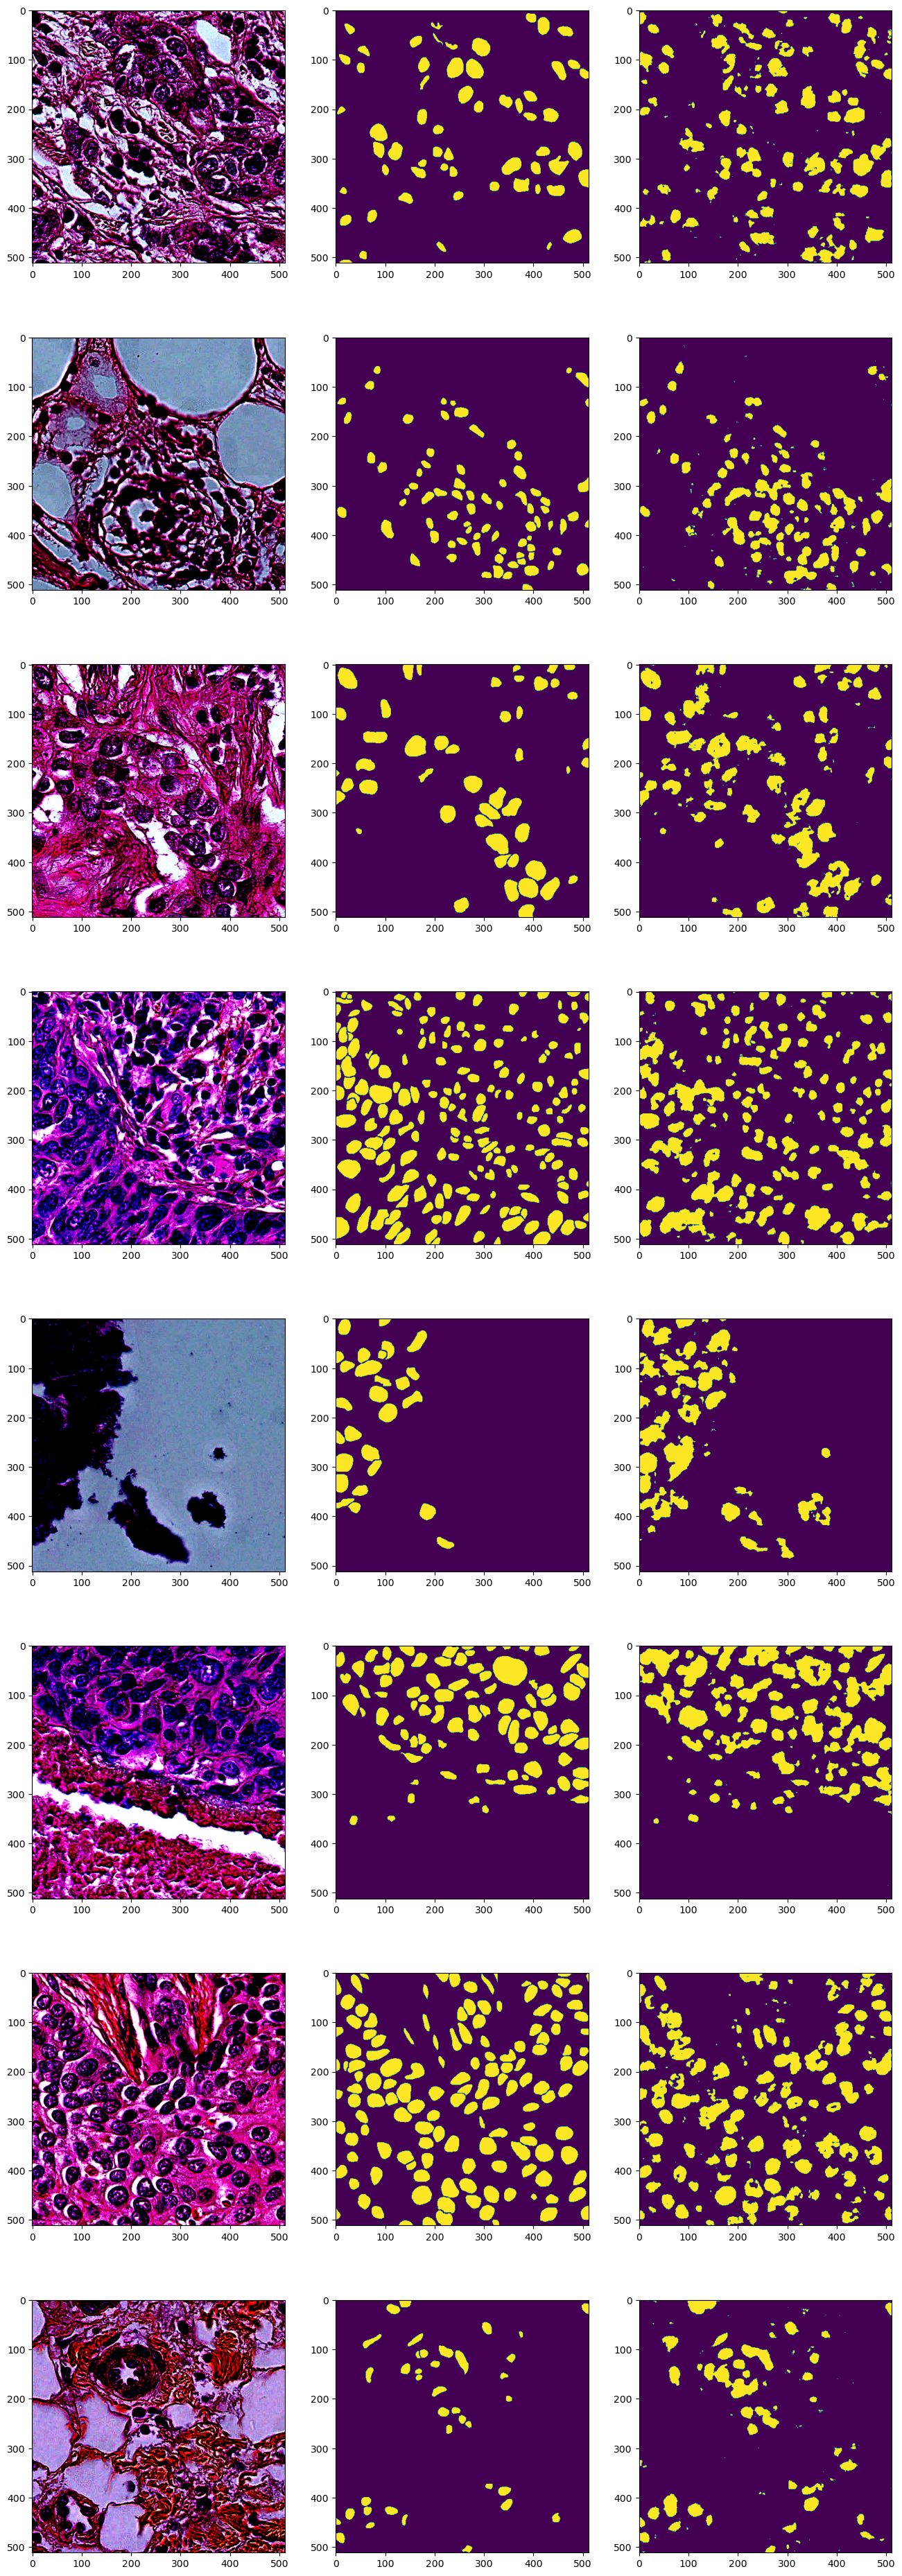

In [121]:
def predict_and_display(model, dataset, n):
    assert n > 0
    fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(16, 6 * n))
    for i in range(n):
        input_img, output_img = dataset[i]
        device_img = input_img.to(device).unsqueeze(0)
        predict_img = torch.where(model(device_img).cpu().detach() > 0, 1, 0)

        axes[i][0].imshow(input_img.permute(1, 2, 0))
        axes[i][1].imshow(output_img.permute(1, 2, 0))
        axes[i][2].imshow(predict_img.squeeze(0).permute(1, 2, 0))

predict_and_display(model, test_dataset, 8)

Train another architecture (either another Unet architecture or find another segmentation model in the available models of Monai). Compare the results with the first model